In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/used-car-dataset-ford-and-mercedes/cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/audi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/toyota.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/skoda.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/ford.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vauxhall.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/bmw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/hyundi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/merc.csv


In [5]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-05-05 15:24:17.067621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746458657.330565      49 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746458657.403464      49 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Data

In [9]:
path = "/kaggle/input/used-car-dataset-ford-and-mercedes"

csv_files = glob.glob(os.path.join(path, "*.csv"))
csv_files = [f for f in csv_files if "unclean" not in f.lower()] 

# Load and combine
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df["source_file"] = os.path.basename(file) 
    dfs.append(df)

# Combine all into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

In [10]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,model,year,price,transmission,mileage,fuelType,engineSize,source_file,tax,mpg,tax(£)
0,C Class,2020,30495,Automatic,1200,Diesel,2.0,cclass.csv,NaN,NaN,NaN
1,C Class,2020,29989,Automatic,1000,Petrol,1.5,cclass.csv,NaN,NaN,NaN
2,C Class,2020,37899,Automatic,500,Diesel,2.0,cclass.csv,NaN,NaN,NaN
3,C Class,2019,30399,Automatic,5000,Diesel,2.0,cclass.csv,NaN,NaN,NaN
4,C Class,2019,29899,Automatic,4500,Diesel,2.0,cclass.csv,NaN,NaN,NaN


In [11]:
df.drop(columns = ['tax','mpg','tax(£)'], inplace = True)

In [12]:
df.drop(columns=['source_file'], inplace=True)

# Data Analysis

In [ ]:
df.drop(columns=['model'], inplace = True)

In [13]:
df.head()

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0


In [14]:
df.shape

(108540, 7)

In [15]:
df.describe()

,year,price,mileage,engineSize
count,108540.000000,108540.000000,108540.000000,108540.000000
mean,2017.098028,16890.124046,23025.928469,1.661644
std,2.130057,9756.266820,21176.423684,0.557058
min,1970.000000,450.000000,1.000000,0.000000
25%,2016.000000,10229.500000,7491.750000,1.200000
50%,2017.000000,14698.000000,17265.000000,1.600000
75%,2019.000000,20940.000000,32236.000000,2.000000
max,2060.000000,159999.000000,323000.000000,6.600000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   engineSize    108540 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 5.8+ MB


In [17]:
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
engineSize      0
dtype: int64

In [18]:
df.duplicated().sum()

10331

In [19]:
df.drop_duplicates(inplace=True)

In [20]:
df.shape

(98209, 7)

In [30]:
for col in df.columns:
    print('*'*50)
    print(col)
    print('-----------')
    print(df[col].unique())

**************************************************
model
-----------
[' C Class' ' Focus' ' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2'
 ' A7' ' TT' ' Q7' ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5'
 ' S8' ' SQ7' ' S3' ' S5' ' A2' ' RS7' ' GT86' ' Corolla' ' RAV4' ' Yaris'
 ' Auris' ' Aygo' ' C-HR' ' Prius' ' Avensis' ' Verso' ' Hilux'
 ' PROACE VERSO' ' Land Cruiser' ' Supra' ' Camry' ' Verso-S' ' IQ'
 ' Urban Cruiser' ' Octavia' ' Citigo' ' Yeti Outdoor' ' Superb' ' Kodiaq'
 ' Rapid' ' Karoq' ' Fabia' ' Yeti' ' Scala' ' Roomster' ' Kamiq'
 ' Fiesta' ' Puma' ' Kuga' ' EcoSport' ' C-MAX' ' Mondeo' ' Ka+'
 ' Tourneo Custom' ' S-MAX' ' B-MAX' ' Edge' ' Tourneo Connect'
 ' Grand C-MAX' ' KA' ' Galaxy' ' Mustang' ' Grand Tourneo Connect'
 ' Fusion' ' Ranger' ' Streetka' ' Escort' ' Transit Tourneo' ' Corsa'
 ' Astra' ' Viva' ' Mokka' ' Mokka X' ' Crossland X' ' Zafira' ' Meriva'
 ' Zafira Tourer' ' Adam' ' Grandland X' ' Antara' ' Insignia' ' Ampera'
 ' GTC' ' Combo Life' 

In [21]:
df[df['year']==2060]

,model,year,price,transmission,mileage,fuelType,engineSize
50752,Fiesta,2060,6495,Automatic,54807,Petrol,1.4


In [22]:
# Fix the invalid year
df.loc[df['year'] == 2060, 'year'] = 2016

# Data Visualization

In [23]:
sns.set(style="darkgrid")

## Numerical Data Columns

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


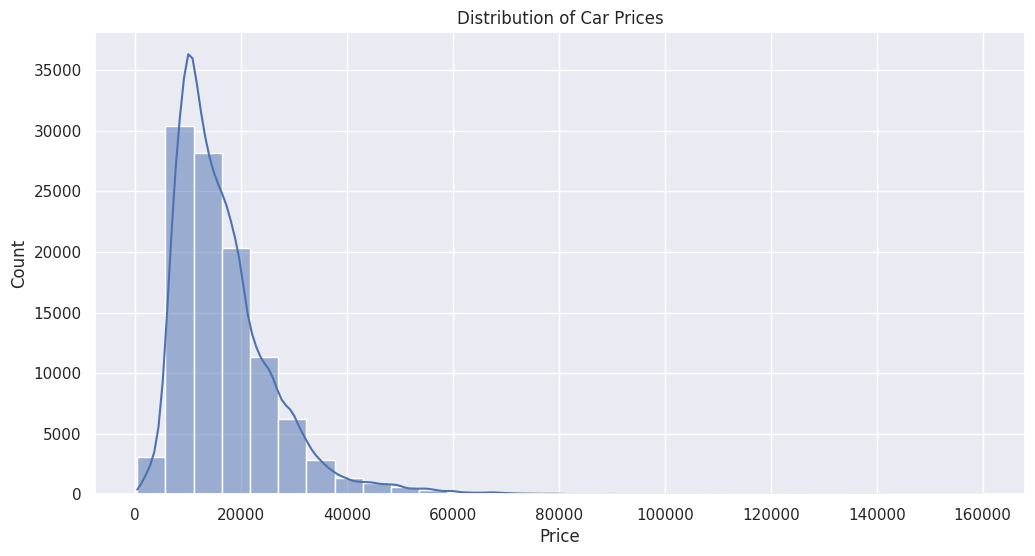

In [41]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='price', bins=30, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

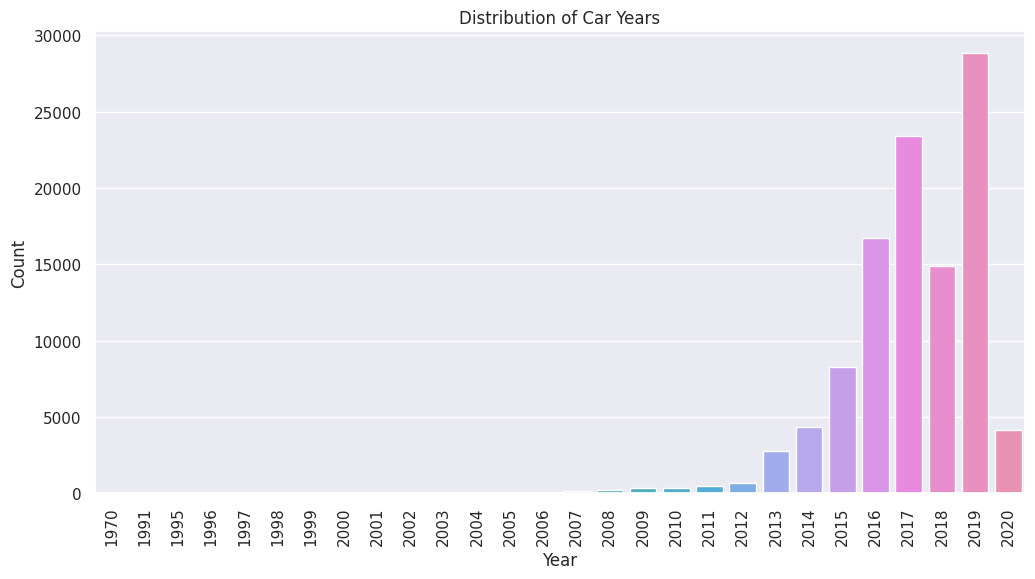

In [42]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='year')
plt.title('Distribution of Car Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


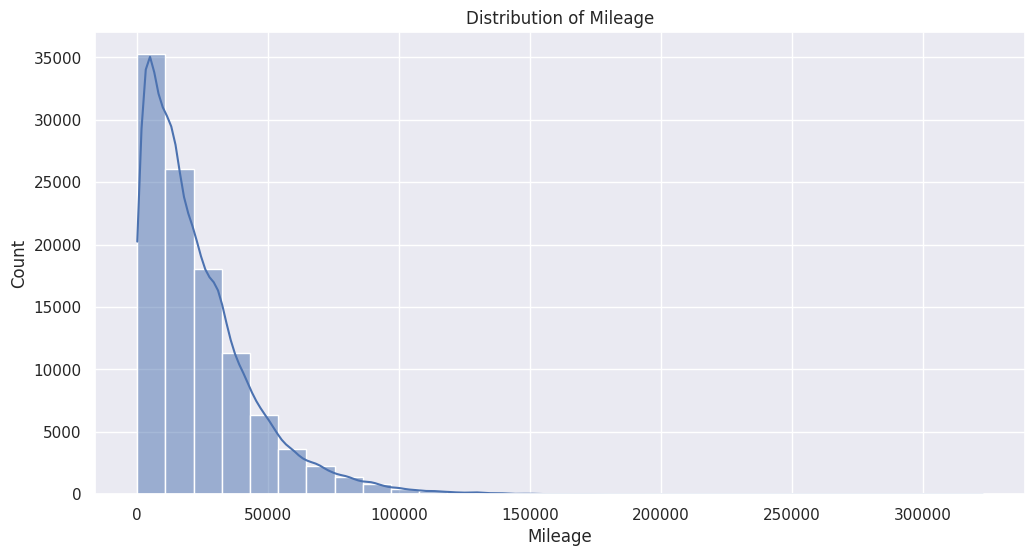

In [43]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='mileage', bins=30, kde=True)
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.show()

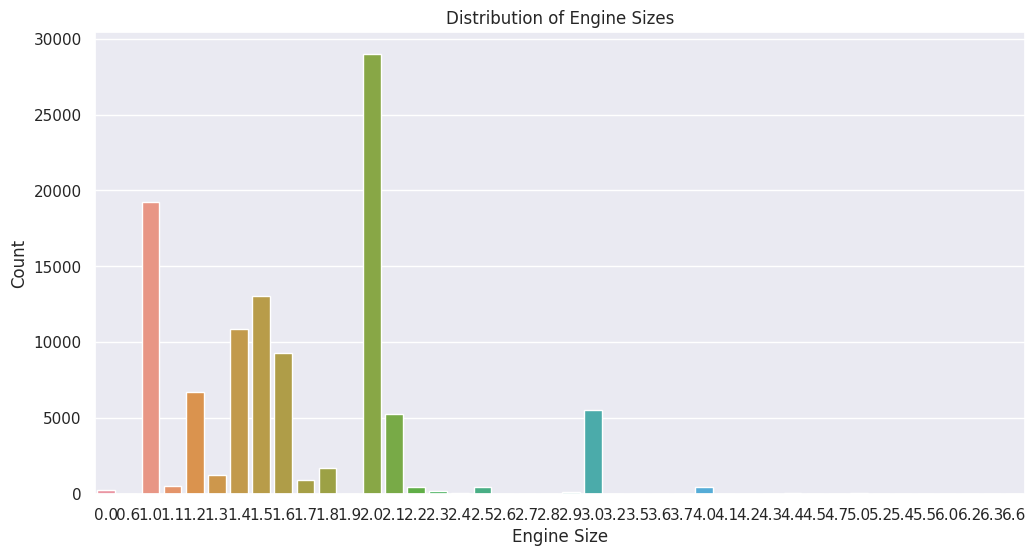

In [44]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='engineSize')
plt.title('Distribution of Engine Sizes')
plt.xlabel('Engine Size')
plt.ylabel('Count')
plt.show()

## Categorical Data Columns

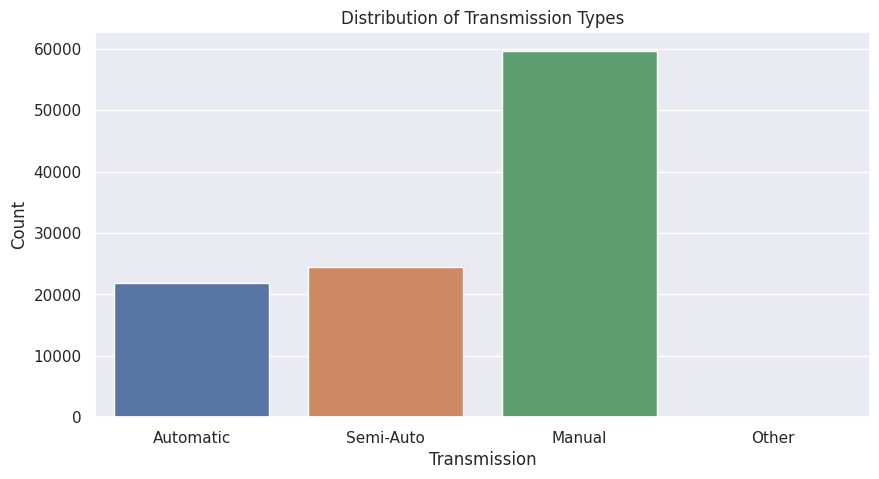

In [45]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='transmission')
plt.title('Distribution of Transmission Types')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.show()

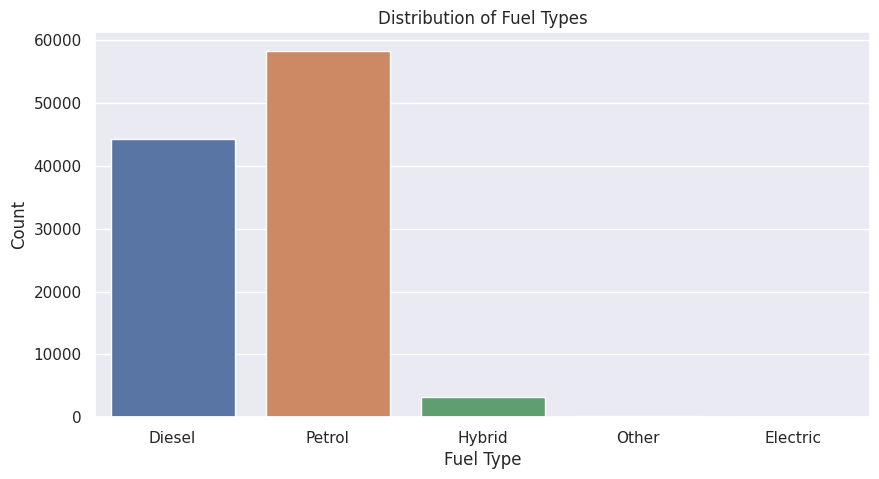

In [46]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='fuelType')
plt.title('Distribution of Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

## Columns Relationships 

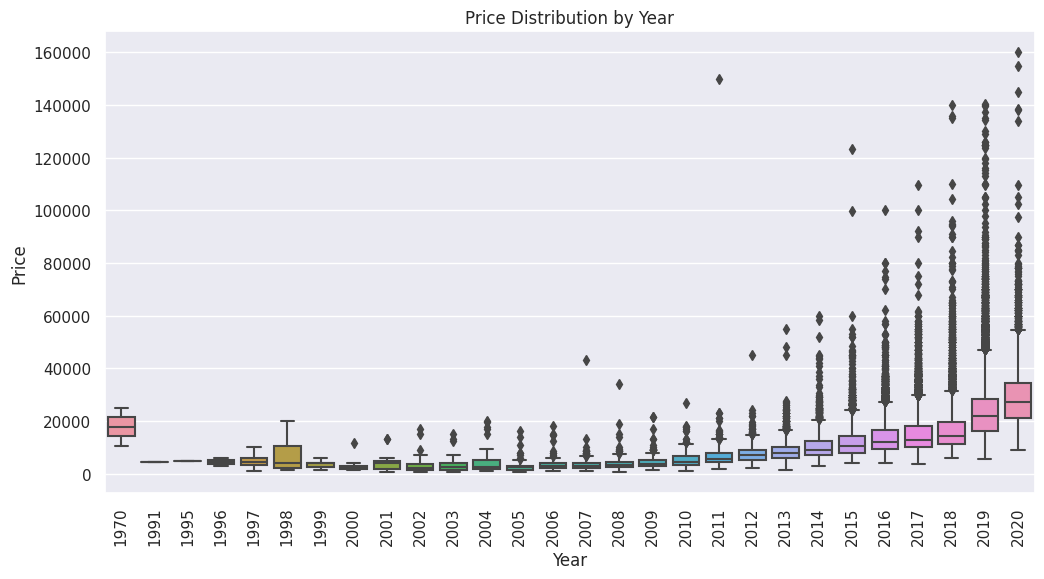

In [50]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='year', y='price')
plt.title('Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

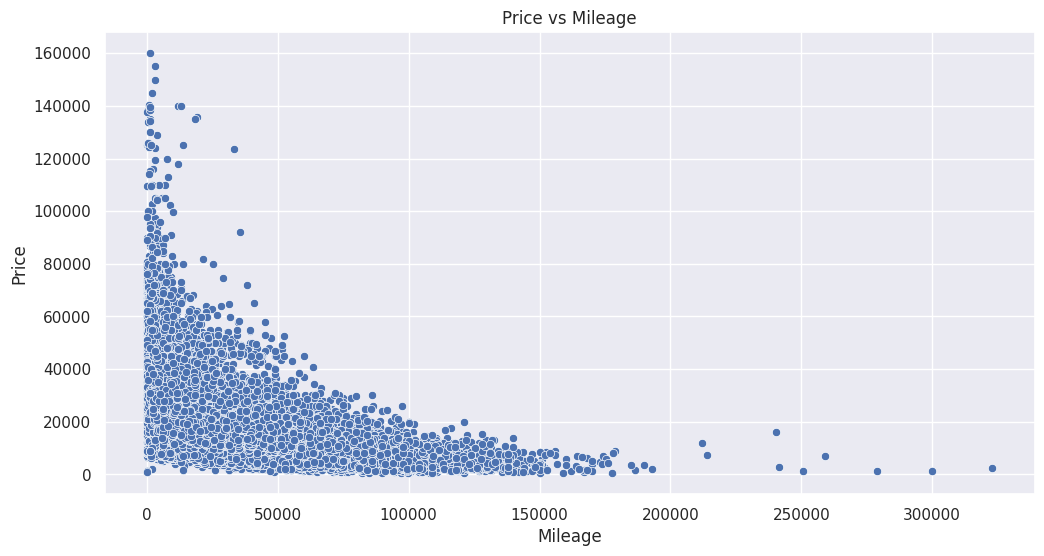

In [51]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='mileage', y='price')
plt.title('Price vs Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

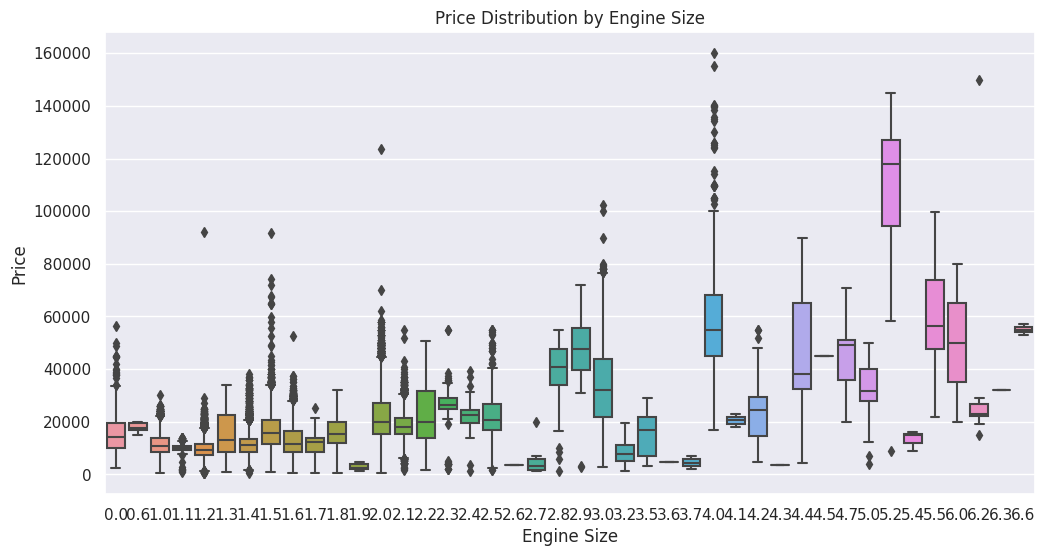

In [52]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='engineSize', y='price')
plt.title('Price Distribution by Engine Size')
plt.xlabel('Engine Size')
plt.ylabel('Price')
plt.show()

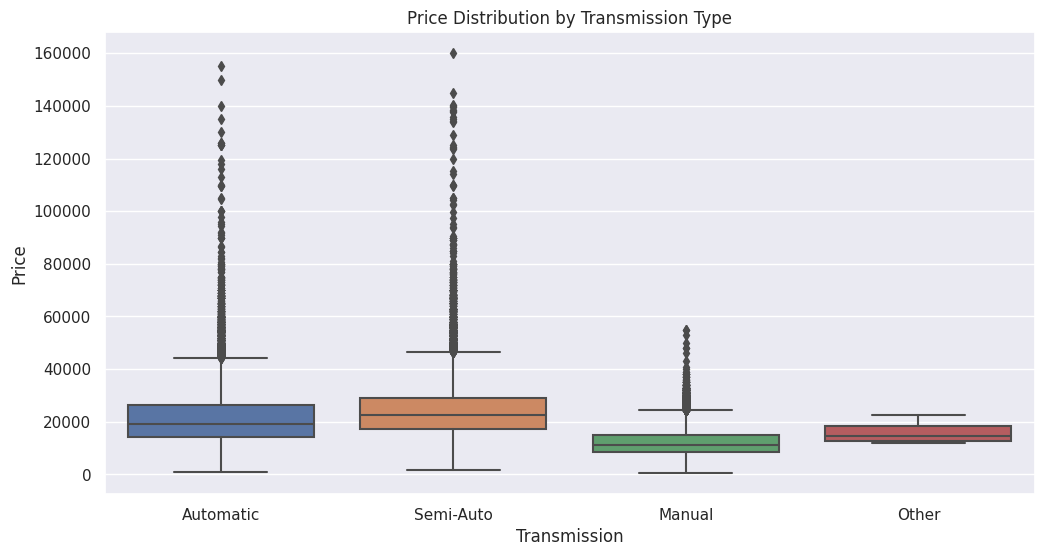

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='transmission', y='price')
plt.title('Price Distribution by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.show()

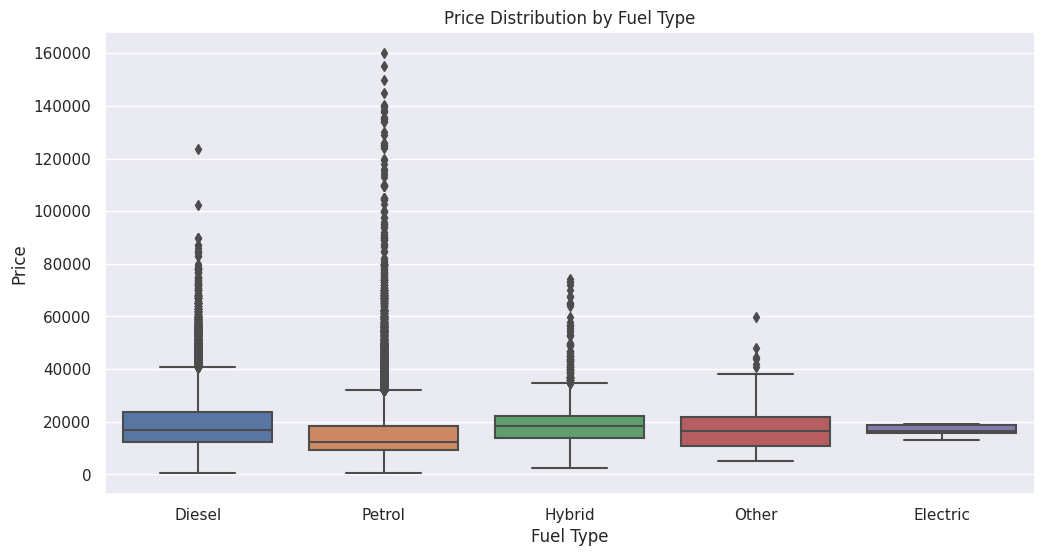

In [54]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='fuelType', y='price')
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

In [106]:
df.drop(columns=['model'], inplace = True)

# Data Preprocessing

## Target Column

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


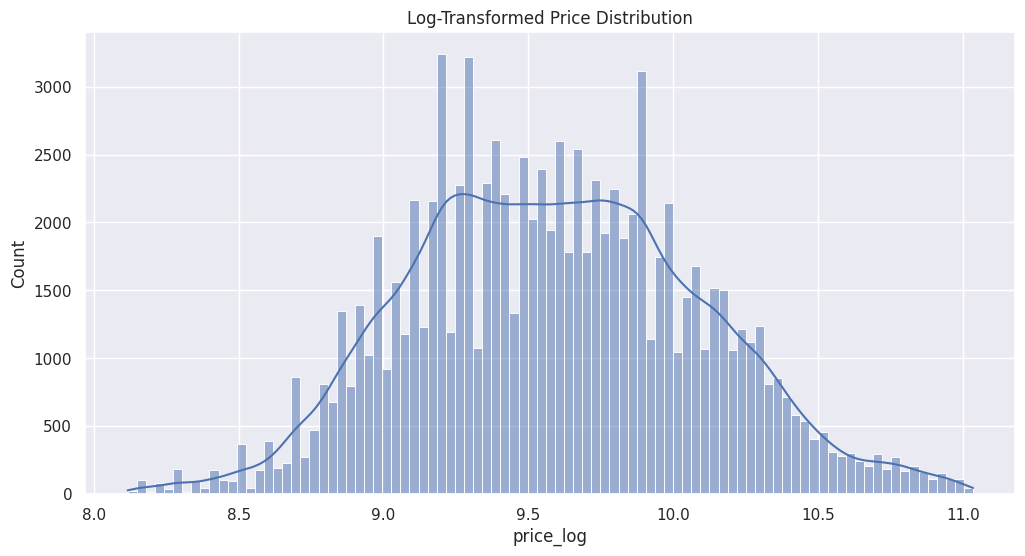

In [24]:
df['price_log'] = np.log1p(df['price'])

Q1 = df['price_log'].quantile(0.25)
Q3 = df['price_log'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price_log'] >= lower_bound) & (df['price_log'] <= upper_bound)]

plt.figure(figsize=(12,6))
sns.histplot(df['price_log'], kde=True)
plt.title('Log-Transformed Price Distribution')
plt.show()

In [25]:
df.drop(columns=['price'], inplace =True)

## Year Column

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


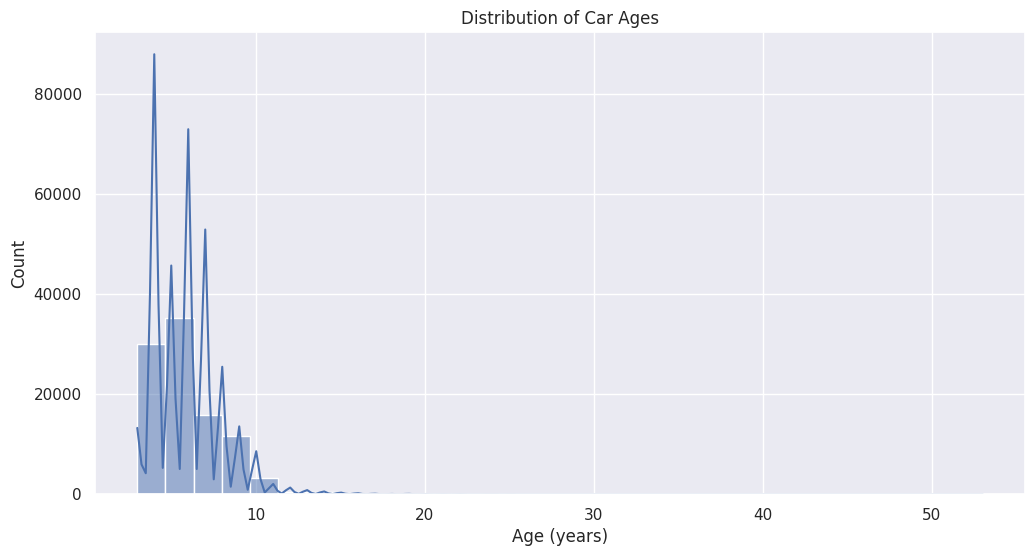

In [26]:
current_year = 2023
df['age'] = current_year - df['year']

df.drop('year', axis=1, inplace=True)

plt.figure(figsize=(12,6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of Car Ages')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

In [27]:
df.columns

Index(['model', 'transmission', 'mileage', 'fuelType', 'engineSize',
       'price_log', 'age'],
      dtype='object')

## Mileage Column

In [28]:
Q1 = df['mileage'].quantile(0.25)
Q3 = df['mileage'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = min(Q3 + 1.5 * IQR, 200000)

# Count how many will be removed before filtering
outliers_count = ((df['mileage'] > upper_bound) | (df['mileage'] < lower_bound)).sum()

# Filter the DataFrame to keep only values within the bounds
df = df[(df['mileage'] <= upper_bound) & (df['mileage'] >= lower_bound)]

print(f"Removed {outliers_count} mileage outliers")


Removed 3511 mileage outliers


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


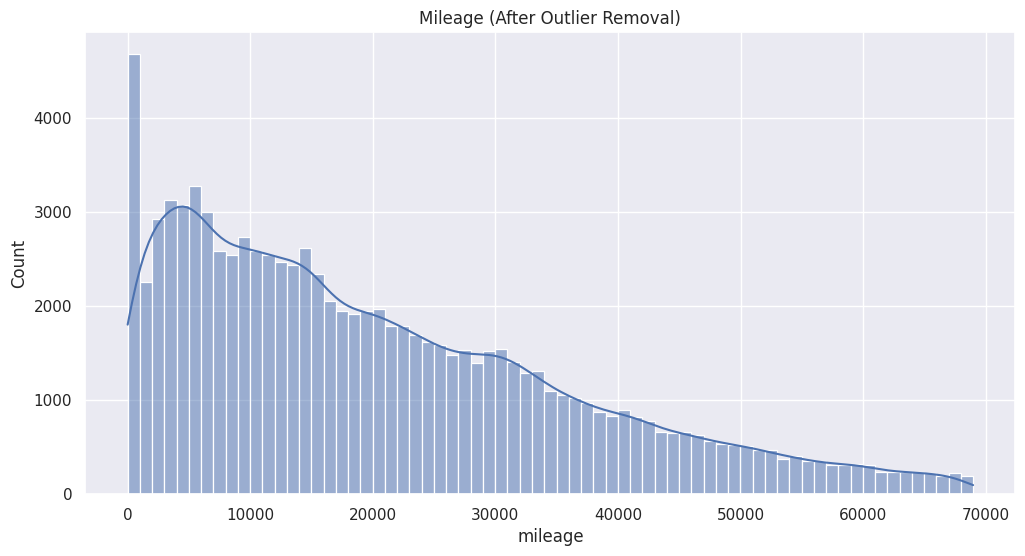

In [29]:
plt.figure(figsize=(12,6))
sns.histplot(df['mileage'], kde=True)
plt.title('Mileage (After Outlier Removal)')
plt.show()

## Engine Size Column

In [30]:
# Bin engine sizes into meaningful categories
bins = [0, 1.0, 1.6, 2.0, 3.0, float('inf')]
labels = ['Small (≤1L)', 'Medium (1-1.6L)', 'Large (1.6-2L)', 'Premium (2-3L)', 'Performance (>3L)']

df['engine_category'] = pd.cut(df['engineSize'], bins=bins, labels=labels)

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


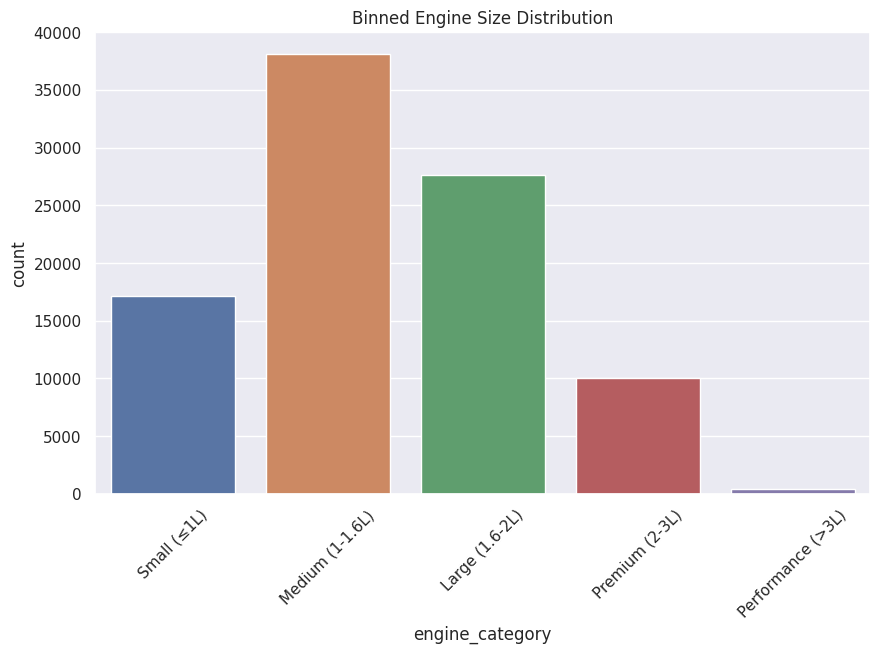

In [31]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='engine_category', order=labels)
plt.title('Binned Engine Size Distribution')
plt.xticks(rotation=45)
plt.show()

In [32]:
#One-Hot Encode for ANN
df = pd.get_dummies(df, columns=['engine_category'], prefix='engine')
df.drop('engineSize', axis=1, inplace=True)

## Transmission Column

In [35]:
#Calculate mean price by transmission type
price_means = df.groupby('transmission')['price_log'].mean().sort_values()

In [36]:
# Create ordinal encoding based on price hierarchy
transmission_map = {
    'Manual': 0,          # Typically lowest price
    'Semi-Auto': 1,       # Mid-range price
    'Automatic': 2,       # Higher price
    'Other': 3            # Special cases (keep separate)
}

In [37]:
df['transmission_encoded'] = df['transmission'].map(transmission_map)

# One-Hot Encode just the 'Other' category
df['transmission_other'] = (df['transmission'] == 'Other').astype(int)

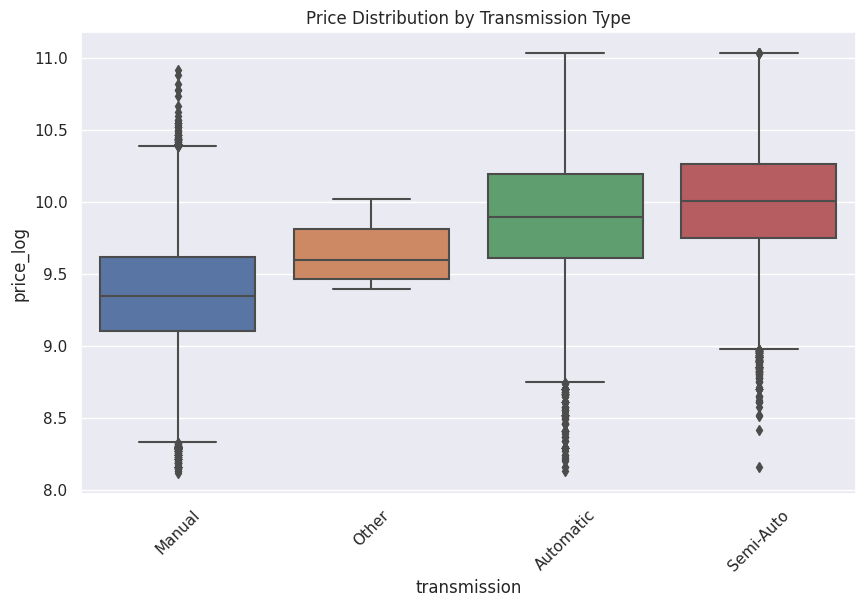

In [39]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='transmission', y='price_log', order=price_means.index)
plt.title('Price Distribution by Transmission Type')
plt.xticks(rotation=45)
plt.show()

In [40]:
df.drop(columns=['transmission'], inplace= True)

## Feul Type

In [41]:
# making hierarchical encoding based on market segments
fuel_encoding = {
    'Diesel': 0,      # Conventional fuel (most common)
    'Petrol': 1,      # Conventional fuel
    'Hybrid': 2,      # Transitional technology
    'Electric': 3,    # Special treatment for EVs
    'Other': 4        # Rare cases (isolate)
}

In [42]:
df['fuel_encoded'] = df['fuelType'].map(fuel_encoding)

# making special binary flags for important categories
df['is_electric'] = (df['fuelType'] == 'Electric').astype(int)
df['is_hybrid'] = (df['fuelType'] == 'Hybrid').astype(int)

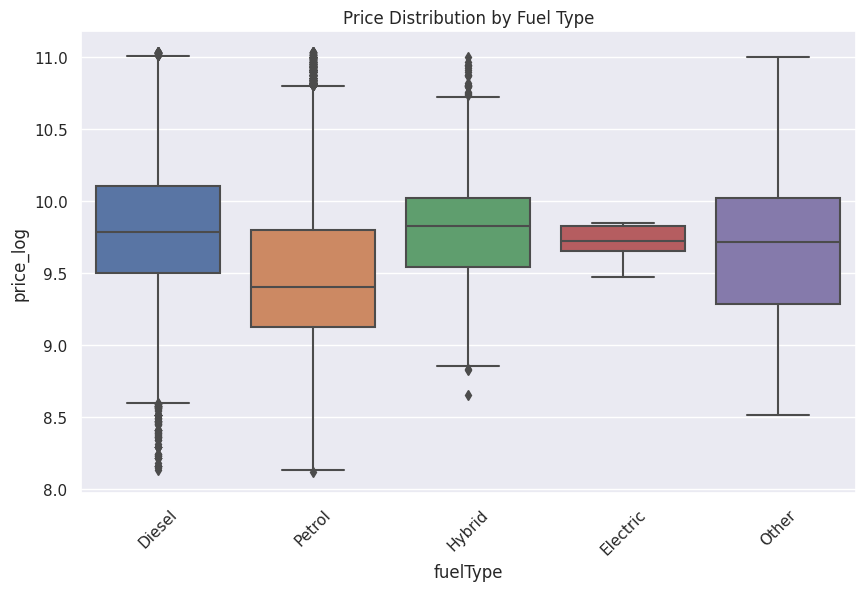

In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='fuelType', y='price_log', 
           order=['Diesel', 'Petrol', 'Hybrid', 'Electric', 'Other'])
plt.title('Price Distribution by Fuel Type')
plt.xticks(rotation=45)
plt.show()

In [44]:
df.drop('fuelType', axis=1, inplace=True)

In [45]:
df.head()

,model,mileage,price_log,age,engine_Small (≤1L),engine_Medium (1-1.6L),engine_Large (1.6-2L),engine_Premium (2-3L),engine_Performance (>3L),transmission_encoded,transmission_other,fuel_encoded,is_electric,is_hybrid
0,C Class,1200,10.325351,3,False,False,True,False,False,2,0,0,0,0
1,C Class,1000,10.308619,3,False,True,False,False,False,2,0,1,0,0
2,C Class,500,10.542706,3,False,False,True,False,False,2,0,0,0,0
3,C Class,5000,10.322198,4,False,False,True,False,False,2,0,0,0,0
4,C Class,4500,10.305614,4,False,False,True,False,False,2,0,0,0,0


## Correlation Between Preprocessed Columns And Output

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


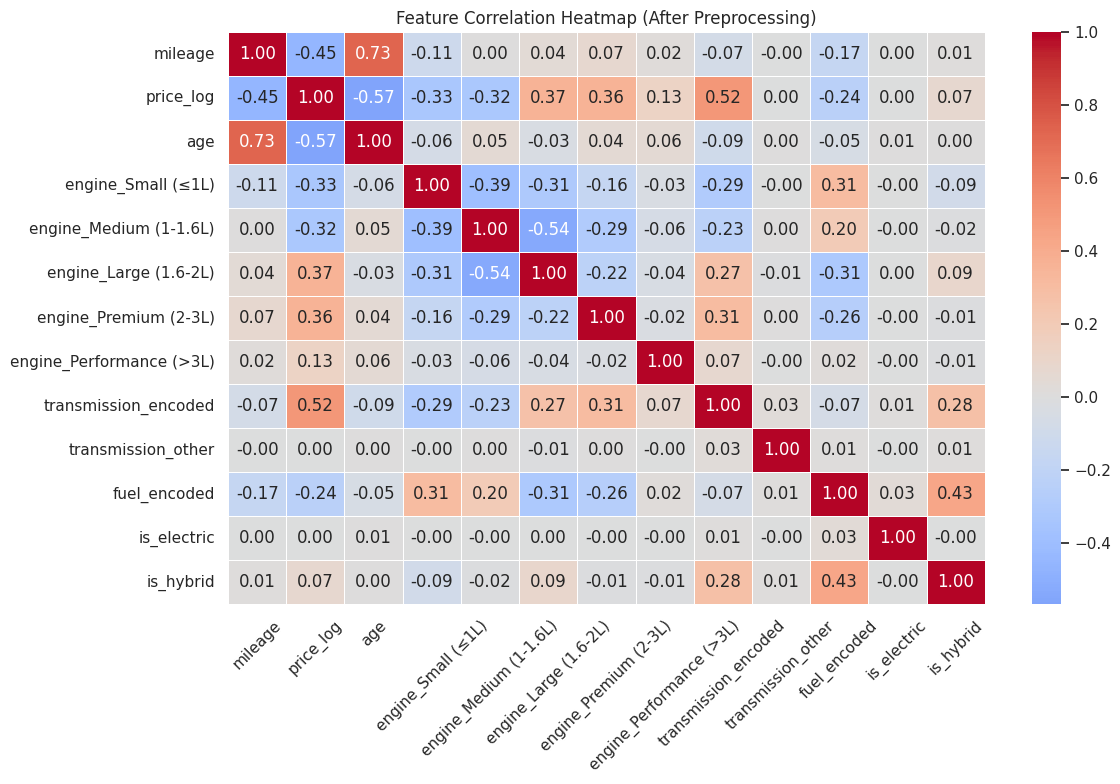

In [49]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', 
            center=0, fmt='.2f', linewidths=.5)
plt.title('Feature Correlation Heatmap (After Preprocessing)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Very Prominent And Strong Correlations Between Target Column And Others :))

In [50]:
df.drop(columns=['is_electric','is_hybrid'], inplace =True)

In [51]:
df.head()

,mileage,price_log,age,engine_Small (≤1L),engine_Medium (1-1.6L),engine_Large (1.6-2L),engine_Premium (2-3L),engine_Performance (>3L),transmission_encoded,transmission_other,fuel_encoded
0,1200,10.325351,3,False,False,True,False,False,2,0,0
1,1000,10.308619,3,False,True,False,False,False,2,0,1
2,500,10.542706,3,False,False,True,False,False,2,0,0
3,5000,10.322198,4,False,False,True,False,False,2,0,0
4,4500,10.305614,4,False,False,True,False,False,2,0,0


# Splitting Of Data

In [95]:
X = df.drop(columns=['price_log'])
y = df['price_log']

In [96]:
X_train,X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [97]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [98]:
X_train.shape

(74908, 10)

In [99]:
X_test.shape

(18728, 10)

# Model Building

In [56]:
from tensorflow.keras import regularizers

In [100]:
model = Sequential([
        Dense(128, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01),
              input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        BatchNormalization(),
        
        Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        BatchNormalization(),
        
        Dense(32, activation='relu'),
        Dense(1)
    ])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse', 
        metrics=['mae']
    )

In [102]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [103]:
history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
)

Epoch 1/100
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 8.5747 - mae: 1.6924 - val_loss: 0.5078 - val_mae: 0.4213
Epoch 2/100
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4621 - mae: 0.4401 - val_loss: 0.2176 - val_mae: 0.3516
Epoch 3/100
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2323 - mae: 0.3729 - val_loss: 0.1914 - val_mae: 0.3520
Epoch 4/100
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2087 - mae: 0.3685 - val_loss: 0.1846 - val_mae: 0.3492
Epoch 5/100
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2055 - mae: 0.3672 - val_loss: 0.1885 - val_mae: 0.3527
Epoch 6/100
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2037 - mae: 0.3665 - val_loss: 0.1892 - val_mae: 0.3549
Epoch 7/100
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2045 - mae: 0.3665 - val_loss: 0.1837 - val_mae: 0.3499
Epoch 8/100
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2070 - mae: 0.3696 - val_loss: 0.1892 - val_mae: 0.3560
Epoch 9/100
2341/2341 ━━━━━━━━━━

### Why Our Model Is Underperforming ?

* Engine size shows non-monotonic relationships
* Transmission encoding has inconsistent correlations
* Missing Non-Linear Relationships:
  

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


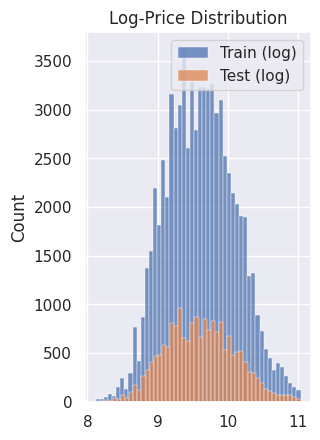

In [186]:
plt.subplot(1,2,2)
sns.histplot(y_train, bins=50, label='Train (log)')
sns.histplot(y_test, bins=50, label='Test (log)')
plt.title('Log-Price Distribution')
plt.legend()
plt.show()

In [115]:
import numpy as np
import pandas as pd

def preprocess_user_input(input_data):
    processed = pd.DataFrame(0, index=[0], columns=[
        'mileage',
        'age',
        'engine_Small (≤1L)',
        'engine_Medium (1-1.6L)',
        'engine_Large (1.6-2L)',
        'engine_Premium (2-3L)',
        'engine_Performance (>3L)',
        'transmission_encoded',
        'transmission_other',
        'fuel_encoded',
        'is_electric',
        'is_hybrid'
    ])
    
    # 1. Process mileage (scale later)
    processed['mileage'] = input_data['mileage']
    
    # 2. Calculate age
    current_year = 2023  # Update as needed
    processed['age'] = current_year - input_data['year']
    
    # 3. Engine size category (from user selection)
    engine_col = f"engine_{input_data['engine_category']}"
    if engine_col in processed.columns:
        processed[engine_col] = 1
    
    # 4. Transmission encoding
    transmission_map = {
        'Manual': 0,
        'Semi-Auto': 1,
        'Automatic': 2,
        'Other': 3
    }
    transmission = input_data['transmission']
    processed['transmission_encoded'] = transmission_map.get(transmission, 3)
    processed['transmission_other'] = 1 if transmission == 'Other' else 0
    
    # 5. Fuel type encoding
    fuel_encoding = {
        'Diesel': 0,
        'Petrol': 1,
        'Hybrid': 2,
        'Electric': 3,
        'Other': 4
    }
    processed['fuel_encoded'] = fuel_encoding.get(input_data['fuelType'], 4)
    
    # Ensure column order matches training data
    final_columns = [
        'mileage',
        'age',
        'engine_Small (≤1L)',
        'engine_Medium (1-1.6L)',
        'engine_Large (1.6-2L)',
        'engine_Premium (2-3L)',
        'engine_Performance (>3L)',
        'transmission_encoded',
        'transmission_other',
        'fuel_encoded',
    ]
    
    return processed[final_columns]

In [127]:
test_input = {
    'year': 2020,
    'mileage': 15000,
    'transmission': 'Automatic',
    'fuelType': 'Diesel',
    'engine_category': 'Large (1.6-2L)'  
}

In [128]:
test_input_preprocessed = preprocess_user_input(test_input)

In [129]:
test_input_preprocessed

,mileage,age,engine_Small (≤1L),engine_Medium (1-1.6L),engine_Large (1.6-2L),engine_Premium (2-3L),engine_Performance (>3L),transmission_encoded,transmission_other,fuel_encoded
0,15000,3,0,0,1,0,0,2,0,0


In [130]:
prediction_log = model.predict(test_input_preprocessed)[0][0]
predicted_price = np.expm1(prediction_log)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [131]:
print("\n=== Prediction Results ===")
print(f"Raw ANN output (log price): {prediction_log:.4f}")
print(f"Converted price: £{predicted_price:,.2f}")


=== Prediction Results ===
Raw ANN output (log price): 9.5972
Converted price: £14,721.93


# Using XGB BOOST

In [75]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [78]:
y_pred_log = xgb.predict(X_test)
y_test_orig = np.expm1(y_test)  
y_pred_orig = np.expm1(y_pred_log)

In [79]:
metrics = {
    'R2': r2_score(y_test_orig, y_pred_orig),
    'MAE': mean_absolute_error(y_test_orig, y_pred_orig),
    'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
    'MAPE': np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100,
    'Median AE': np.median(np.abs(y_test_orig - y_pred_orig))
}

In [80]:
print("\n=== XGBoost Evaluation ===")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


=== XGBoost Evaluation ===
R2: 0.8071
MAE: 2774.8201
RMSE: 3932.0071
MAPE: 17.2566
Median AE: 2029.0200


# Exporting Models

In [124]:
import joblib
from tensorflow.keras.models import save_model
import json


In [133]:
model.save('ann_model_@.h5', save_format='h5') 

In [134]:
model.save('ann_model.keras') 

In [126]:
joblib.dump(xgb, 'xgb_model.joblib')

['xgb_model.joblib']